In [ ]:
# default_exp clone_analysis

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Clone Analysis Functions

## data wrangling functions

In [ ]:
# export
def _combine_agg_functions(additional_agg_functions):
    if additional_agg_functions is None:
        additional_agg_functions = {}

    agg_functions = {"label": "count", "area_um2": [np.mean, np.std]}
    return {**agg_functions, **additional_agg_functions}

In [ ]:
# export
def _individual_filter_condition(
    df, filtered_col_name: str, query: str, clone_channel: str, agg_functions
):
    if query is not None:
        df = df.query(query)

    temp_df = (df.groupby(["int_img", clone_channel]).agg(agg_functions)).copy()

    temp_df.columns = pd.MultiIndex.from_tuples(
        [(filtered_col_name,) + a for a in temp_df.columns]
    )
    return temp_df

In [ ]:
# export
def query_df_groupby_by_clone_channel(
    df, queries: dict, clone_channel: str = "C1", additional_agg_functions: dict = None,
):
    """additional agg_functions could be something like:
    additional_agg_functions = {"mean_intensity": [np.mean, np.std]}"""

    agg_functions = _combine_agg_functions(additional_agg_functions)
    df = df.reset_index()

    l = list()
    for key, query in queries.items():
        l.append(
            _individual_filter_condition(df, key, query, clone_channel, agg_functions)
        )

    return reduce(
        lambda df_left, df_right: pd.merge(
            df_left, df_right, how="outer", left_index=True, right_index=True
        ),
        l,
    )

## data visualization functions

In [ ]:
def create_stack_bar_plot(
    df,
    df_error_bar=None,
    x_figSize=2.5,
    y_figSize=2.5,
    y_label=None,
    y_axis_start=0,
    y_axis_limit=None,
    color_pal=sns.color_palette(palette="Blues_r"),
    bar_width=0.8,
):

    fig, ax = plt.subplots(figsize=(x_figSize, y_figSize))

    sns.set(style="ticks")
    sns.despine()

    ax = df.plot(
        kind="bar",
        stacked=True,
        color=color_pal,
        width=bar_width,
        ax=ax,
        yerr=df_error_bar,
        capsize=4,
    )
    ax.set_ylabel(y_label, fontsize=12)
    sns.despine(ax=ax)
    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=1)
    ax.tick_params(axis="both", which="major", pad=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.setp(ax.spines.values(), linewidth=1)

    if not y_axis_limit == None:
        ax.set_ylim(top=y_axis_limit)

    handles, labels = ax.get_legend_handles_labels()

    ax.legend(
        reversed(handles), reversed(labels), bbox_to_anchor=(1, 1), loc="upper left"
    )

In [ ]:
from dask.distributed import Client

from py_clone_detective.clone_counters import LazyCloneCounter

In [ ]:
c = Client()
c

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:56460,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:56469,Total threads: 2
Dashboard: http://127.0.0.1:56471/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:56463,


## Example using LazyCloneCounter with measure_overlap

In [ ]:
bar = LazyCloneCounter("Marcm2a_E7F1", r"a\dg\d\dp\d", 0.275)

bar.add_images(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_imgs/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_imgs/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_imgs/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_imgs/*.tif*",
)

bar.add_segmentations(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_label_imgs_combined_C3/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_binaries/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_label_imgs_v2/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_label_imgs/*.tif*",
)
bar.make_measurements(extra_properties=["convex_area"],)
bar.measure_overlap()
bar.combine_C0_overlaps_and_measurements()

## Example using LazyCloneCounter with add_clones_and_neighbouring_labels

In [ ]:
from skimage import morphology

In [ ]:
foo = LazyCloneCounter("Marcm2a_E7F1", r"a\dg\d\dp\d", 0.275)

foo.add_images(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_imgs/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_imgs/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_imgs/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_imgs/*.tif*",
)

In [ ]:
foo.add_segmentations(
    morphology.remove_small_objects,
    ad_func_kwargs={"min_size": 49},
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_label_imgs_combined_C3/*.tif*",
)

In [ ]:
foo.make_measurements()

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C1" & mean_intensity > 1000',
    name_for_query="C1",
    calc_clones=True,
)

In [ ]:
foo.results_measurements = foo.results_measurements.eval(
    "total_intensity = mean_intensity * area"
)

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C2" & total_intensity > 5e5',
    name_for_query="C2",
    calc_clones=False,
)

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C3" & mean_intensity > 5000',
    name_for_query="C3",
    calc_clones=False,
)

In [ ]:
foo.measure_clones_and_neighbouring_labels(name_for_query="C1")
foo.measure_clones_and_neighbouring_labels(name_for_query="C2")
foo.measure_clones_and_neighbouring_labels(name_for_query="C3")

df = foo.combine_neighbour_counts_and_measurements()

In [ ]:
df = df[np.invert(df.eval('C2_pos == C3_pos == True'))]

In [ ]:
grouped_df = query_df_groupby_by_clone_channel(
    df.query('int_img_ch == "C1"').reset_index(),
    queries={
        "Total": None,
        "C2negC3neg_C0area_less_than_50um2": "C2_pos == False & C3_pos == False & area_um2 <= 50",
        "C2negC3neg_C0area_greater_than_50um2": "C2_pos == False & C3_pos == False & area_um2 > 50",
        "C2_pos_count": "C2_pos == True",
        "C3_pos_count": "C3_pos == True",
    },
    clone_channel="C1_clone",
)

In [ ]:
idx = pd.IndexSlice

In [ ]:
grouped_df = (
    grouped_df.stack((1, 2))
    .loc[idx[:, :, "label", "count"]]
    .reset_index((2, 3), drop=True)
    .reset_index()
)

In [ ]:
grouped_df["genotype"] = grouped_df["int_img"].str.extract(r"(a\d)")

In [ ]:
percentage_df = grouped_df.eval(
    """
C2negC3neg_C0area_less_than_50um2 = C2negC3neg_C0area_less_than_50um2 / Total * 100
C2negC3neg_C0area_greater_than_50um2 = C2negC3neg_C0area_greater_than_50um2 / Total * 100
C2_pos_count = C2_pos_count / Total * 100
C3_pos_count = C3_pos_count / Total * 100
"""
)

In [ ]:
inside_clone = grouped_df.query("C1_clone != 0").drop(columns=["Total", "C1_clone"])
inside_clone_percentage = percentage_df.query("C1_clone != 0").drop(columns = ["Total"]).fillna(0)

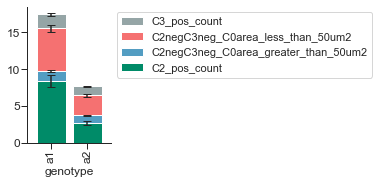

In [ ]:
create_stack_bar_plot(
    inside_clone.groupby("genotype").mean(),
    inside_clone.groupby("genotype").sem(),
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
)

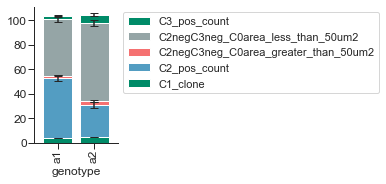

In [ ]:
create_stack_bar_plot(
    inside_clone_percentage.groupby("genotype").mean(),
    inside_clone_percentage.groupby("genotype").sem(),
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
)